In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pypdf
import torch.nn.functional as F
import numpy as np
import os

In [2]:
df = pd.read_csv(r'C:\Users\Rick\lulu\Indian-Male-Names.csv',index_col=False)
df = df.drop('gender',axis = 1)
df

,name,race
0,barjraj,indian
1,ramdin verma,indian
2,sharat chandran,indian
3,birender mandal,indian
4,amit,indian
...,...,...
14840,buddha,indian
14841,mukesh,indian
14842,monu,indian
14843,govind prasad shahu,indian


In [7]:
dy = pd.read_csv(r'C:\Users\Rick\lulu\Indian-Female-Names.csv',index_col=False)
dy = dy.drop('gender',axis = 1)
dy

,name,race
0,shivani,indian
1,isha,indian
2,smt shyani devi,indian
3,divya,indian
4,mansi,indian
...,...,...
15377,saroj devi,indian
15378,naina @ geeta,indian
15379,manju d/0 baboo lal jatav,indian
15380,shivani,indian


In [5]:
df = df.drop('race',axis = 1)


In [8]:
dy = dy.drop('race',axis = 1)


In [9]:
dy

,name
0,shivani
1,isha
2,smt shyani devi
3,divya
4,mansi
...,...
15377,saroj devi
15378,naina @ geeta
15379,manju d/0 baboo lal jatav
15380,shivani


In [6]:
df = df.drop_duplicates()

In [10]:
dy = dy.drop_duplicates()

In [7]:
df.to_csv('Names_to_train.txt', index=False, header=False)

In [12]:
dy.to_csv('Female_Names_to_train.txt', index=False, header=False)

In [2]:
char_to_rem = '/\\`0123456789@.,;}-()&"$+:[]{}' + 'अआइईउऊएऐओऔऋअंकखगघड़चछजझञटठडढणतथदधनपफबभमयरलवशषसह' + 'ा' + 'ि' + 'ी' + 'ु' + 'ू' + 'े' + 'ो' + '्' + '\u200d' + '�' + 'ì'+ 'ै'

def clean_char(name_of_folder):
    with open(name_of_folder, "r", encoding='utf-8') as f:
        content = f.read()
    cleaned_text = ''.join(char for char in content if char not in char_to_rem)
    
    # Split into lines
    lines = cleaned_text.splitlines()  
    processed_lines = []
    
    for line in lines:
        words = line.splitlines()  # Split words on whitespace
        if words:
            processed_lines.extend(words)  # Append each word separately

    # Join words with a newline character
    final_output = '\n'.join(processed_lines)
    
    with open("Names_to_train.txt", "w", encoding='utf-8') as f:
        f.write(final_output)

# Call the function with the appropriate file name
clean_char("Names_to_train.txt")


In [7]:
import random
def read_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()  # Read the entire content

# Function to write combined content to a new file
def write_to_file(file_path, content):
    with open(file_path, 'w') as file:
        file.write(content)  # Write content to the output file

# Paths to your text files
file1_path = 'Names_to_train.txt'
file2_path = 'Female_Names_to_train.txt'
output_file_path = 'cleaned_dataset.txt'

# Read both files
text1 = read_file(file1_path)
text2 = read_file(file2_path)

# Combine the contents of both files
combined_text = text1 + '\n' + text2  # Add a newline between the two files
text_list = combined_text.splitlines()
random.shuffle(text_list)
shuffled_text = '\n'.join(text_list)
# Write the combined content to the output file
write_to_file(output_file_path, shuffled_text)

print(f"Files have been successfully joined into {output_file_path}.")


Files have been successfully joined into cleaned_dataset.txt.


In [2]:
with open('cleaned_dataset.txt','r',encoding='utf-8')as f:
    words = f.read()
    words = words.lower()
    words = words.splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [3]:
block_size = 3 
X, Y = [], []
for w in words:
  #print(w)
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42)

In [21]:
generator = torch.manual_seed(6)
C = torch.randn(28,10)
w1= torch.randn((30,500)) * 0.01
b1 = torch.randn(500) * 0.01
w2 = torch.randn((500,200)) * 0.01
b2 = torch.randn(200) * 0.01
w3 = torch.randn(200,28)
b3 = torch.randn(28)
parameters = [C, w1, b1, w2, b2, w3, b3]

In [22]:
for p in parameters:
  p.requires_grad = True

In [23]:
sum(p.nelement() for p in parameters)

121608

In [66]:
lre = torch.linspace(-2, 0, 100)
lrs = 10**lre

In [7]:
lri = []
lossi = []
stepi = []

In [27]:
for i in range(50000):
  
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (200,))
    
    # forward pass
    emb = C[X_train[ix]]  # Ensure minibatch size is correct
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1)  # (200, 500)
    logits = h @ w2 + b2  # (200, 100)
    logits = logits @ w3 + b3  # Final layer (200, 28)
    loss = F.cross_entropy(logits, y_train[ix])  # Cross-entropy loss
    if i % 5000 == 0:
        print(f"Step {i}, Loss: {loss.item()}")
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad
        



Step 0, Loss: 2.0322306156158447
Step 5000, Loss: 1.7779757976531982
Step 10000, Loss: 1.8471745252609253
Step 15000, Loss: 1.811324119567871
Step 20000, Loss: 1.784348726272583
Step 25000, Loss: 1.8055344820022583
Step 30000, Loss: 1.9415019750595093
Step 35000, Loss: 1.9460994005203247
Step 40000, Loss: 1.8450747728347778
Step 45000, Loss: 1.8386393785476685


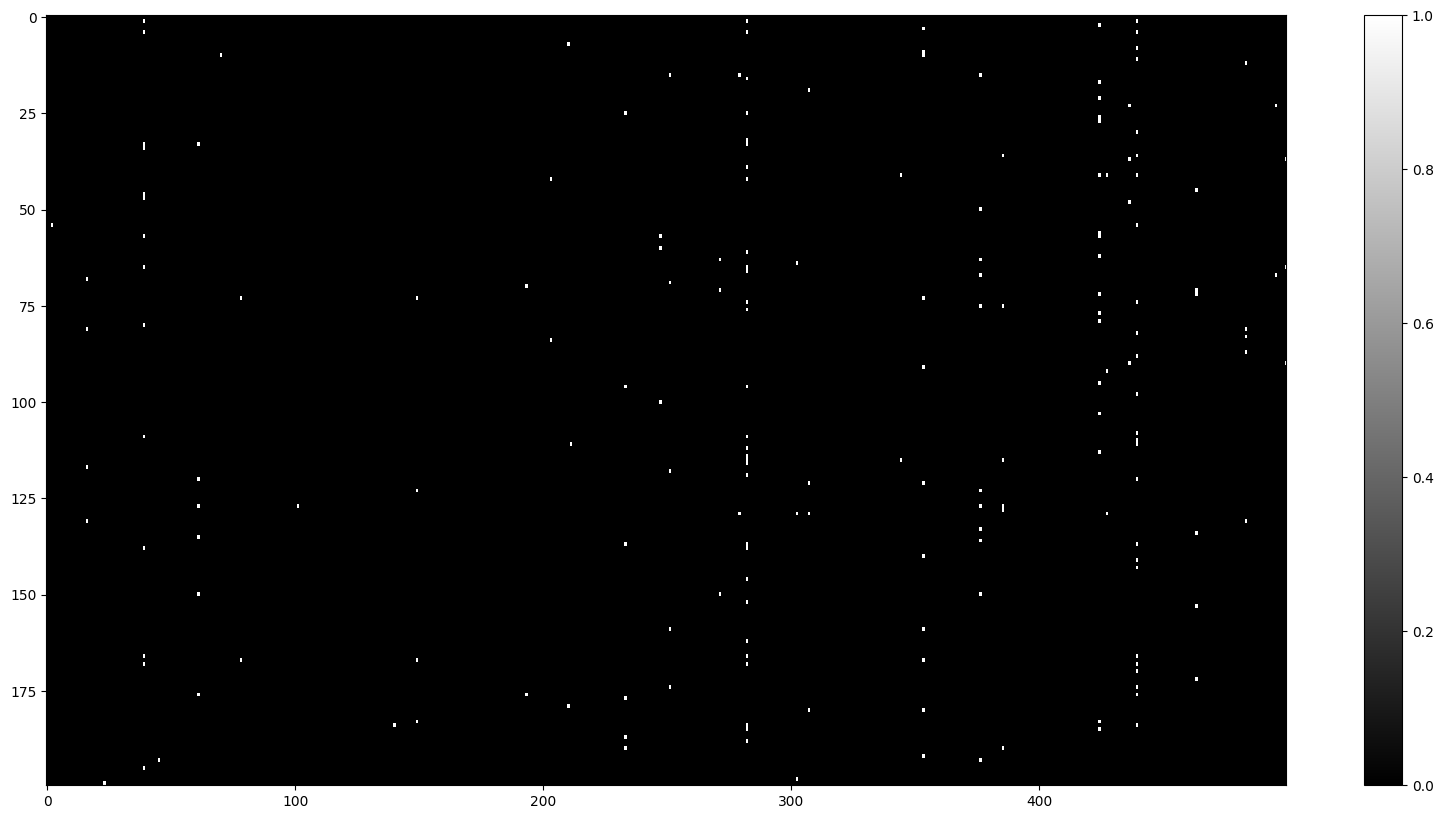

In [25]:
plt.figure(figsize=(20, 10), dpi=100)  # Increase DPI for better resolution
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto')  # Set aspect to auto
plt.colorbar()
plt.show()


In [28]:
g = torch.Generator().manual_seed(6 + 10)

for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      logits_last = logits @ w3 + b3
      probs = F.softmax(logits_last, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

dhika.
aash mwendra.
shand kumari lha.
priya.
munita.
rajesh.
mika.
dishmrita.
rajesh saireena.
sunaradeesh lal.
kitwal.
preesh.
rosh.
raj khanikhan kumaren.
samadanishi.
adul.
faran larma.
kirshal.
kumari.
rajender.
kar.
pootna bajrish chaudh kumar pan shakari poon sona khand il kumar.
bip kujam.
aartila singh.
jaesh man sinwari bhurjhi.
sar.
rina mahadak.
mohapsrajoly .
ajiya.
sugan vijayakalalya sakshari.
meem  kir mani.
geitharmelyan.
jayna kumarinakma banla khati.
kumar.
pamali gurgreena mahia bhashakir singh.
guli.
manth.
kumash.
abdul kumari wo jay  gupta.
smt davbi.
narojya.
gull.
naipursharuna lal.
anki kana.
girpal.
ghoon.
san  kumar.
smt singh rasvara.
jan.
surejesh cke.
yogi.
sanjassunak.
sanj.
reola.
shad singh  gupta.
nazda.
riti.
aiswal malam.
ash vurnil sajeet singh.
neena priya.
bed.
chandar.
meha pal sasharma.
abdulta.
subha dasbanoj vendar.
mahila.
shyam.
neeram.
sarima.
meet.
mam.
sena.
bes geepal.
abha.
ku pal.
sondv tarvi kumari shak.
divano.
harmil nati sahgafuma